# Sentiment Analysis and Emotion Detection of Twitch Data

## Loading data into notebook

In [ ]:
!wget https://github.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/blob/main/data/twitch_data.csv.zip?raw=true

--2021-08-10 13:49:22--  https://github.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/blob/main/data/twitch_data.csv.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/raw/main/data/twitch_data.csv.zip [following]
--2021-08-10 13:49:22--  https://github.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/raw/main/data/twitch_data.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/main/data/twitch_data.csv.zip [following]
--2021-08-10 13:49:23--  https://raw.githubusercontent.com/JefNtungila/Sentiment-Analysis-of-U

In [ ]:
!unzip twitch_data.csv.zip?raw=true

Archive:  twitch_data.csv.zip?raw=true
  inflating: twitch_data.csv         
  inflating: __MACOSX/._twitch_data.csv  


In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 500

#reading data in

twitch_data = pd.read_csv('twitch_data.csv')

In [ ]:
twitch_data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,139500,NaN,NaN,NaN,69749.5,40270.3,0,34874.8,69749.5,104624,139499
reference_index,139500,NaN,NaN,NaN,49.5,28.8662,0,24.75,49.5,74.25,99
user_name,139500,4062,ops1x,937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_name,138386,1378,Grand Theft Auto V,12780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,139043,43567,Ramee | !Twitter | Chang Gang | NoPixel,299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
viewer_count,139500,NaN,NaN,NaN,7108.38,12417.7,0,2254,3430,6788,400648
started_at,139500,34500,2021-06-17 08:00:29,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
api_call_time,139500,1395,2021-06-07T07:06:03.073801,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_api_call_time,139500,62,2021-06-18,2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hour_api_call_time,139500,NaN,NaN,NaN,11.8222,6.80187,0,6,12,18,23


In [ ]:
twitch_data.columns.values

array(['Unnamed: 0', 'reference_index', 'user_name', 'game_name', 'title',
       'viewer_count', 'started_at', 'api_call_time',
       'date_api_call_time', 'hour_api_call_time', 'tokenised_title',
       'tokenised_titles_with_stopwords', 'genre', 'words_in_names'],
      dtype=object)

## Wrangling Data into required format for analysis

In [ ]:
#keep title with min amount of views i.e first time video appear on the twitch trending tab

twitch_min_views = twitch_data.drop_duplicates(subset=['started_at','user_name','title'], 
                                                 keep='first')[['started_at', 'date_api_call_time', 'hour_api_call_time', 'user_name','title',
                                                                'tokenised_title', 'genre', 'words_in_names', 'viewer_count']]

#keep title with max amount of views, sorting by maximum viewer count and keeping first
twitch_max_views = twitch_data.sort_values(by='viewer_count', ascending = False).drop_duplicates(subset=['started_at','user_name','title'], 
                                                 keep='first')[['started_at','user_name','title','viewer_count', 'date_api_call_time', 'hour_api_call_time']]

#merging both min and max views dataframe and then renaming columns
twitch_views = pd.merge(twitch_min_views, twitch_max_views, how = 'left', on = ['started_at','user_name','title'])
twitch_views = twitch_views.rename(columns = {'viewer_count_x': 'min_views',
                                'viewer_count_y': 'max_views',
                                'date_api_call_time_x' : 'entry_date',
                                'hour_api_call_time_x' : 'entry_hour',
                                'date_api_call_time_y':'exit_date',
                                'hour_api_call_time_y' : 'exit_hour'})   

#calculating the percentage increase                                                        
view_increase = twitch_views['max_views'] - twitch_views['min_views']
percentage_view_increase = view_increase/twitch_views['min_views'] 

twitch_views['percentage_view_increase'] = percentage_view_increase 

#VALIDITY , views that were ingested through reversal of the api
# observations that decreased or had no increase at all in viewership
twitch_views = twitch_views[twitch_views['min_views'] > 0]
twitch_views = twitch_views[twitch_views['max_views'] > 0]
twitch_views = twitch_views[twitch_views['percentage_view_increase'] > 0]

## Performing Sentiment Anaysis on Twitch Data using Vader and Emote-controlled



Vader reference:

Hutto, C. and Gilbert, E., 2014, May. Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Proceedings of the International AAAI Conference on Web and Social Media (Vol. 8, No. 1).

Emote-controlled reference:

Kobs, K., Zehe, A., Bernstetter, A., Chibane, J., Pfister, J., Tritscher, J. and Hotho, A., 2020. Emote-Controlled: Obtaining Implicit Viewer Feedback Through Emote-Based Sentiment Analysis on Comments of Popular Twitch. tv Channels. ACM Transactions on Social Computing, 3(2), pp.1-34.



In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
#downloading vader lexincon but what is vader lexicon???????
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [ ]:
#reading tsv in as dataframe
emote_controlled = pd.read_csv('https://raw.githubusercontent.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/main/data/emote_average', sep='\t')

#preprocessing emotes as lowercase given that the tokenised titles are all lower case
emote_controlled['word'] = emote_controlled['word'].str.lower()

#converting tsv to dictionary for ease of look up of words
emote_controlled  = emote_controlled.set_index('word').T.to_dict('list')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  


In [ ]:

def emote_analyser(doc):
  
  ''' takes in a sentence document
  returns emote senrtiment as defined by Kobs et al'''

  #preprocessing string to extract list
  doc = eval(doc)

  emote_final_sentiment = []  

  for word in doc:
    try:
      #try finding emote in dictionary
      #if emote is found appent polarity
      emote_sentiment = emote_controlled[word][0]
      emote_final_sentiment.append(emote_sentiment)
    except:
      continue
   #return maximum sentiment for emote 
  if sum(emote_final_sentiment) != 0:
     return max(emote_final_sentiment, key = abs)
  else:
    return 0


emotes =  twitch_views['tokenised_title'].apply(lambda x: emote_analyser(x))

print(len(emotes)) #how many titles were analysed
print(sum(emotes)) #if zero than error with function
print(len([i for i in emotes if i != 0])) #how many titles had emotes
print(len([i for i in emotes if i != 0])/len(emotes)) #percentage titles that had emotes




23578
101.06999999999987
269
0.011408940537789465


In [ ]:
def sentiment_analyser(doc):
#making long string from each token
  # doc = ' '.join(word for word in doc) 
  sid = SentimentIntensityAnalyzer()
  output = sid.polarity_scores(doc)
  sentiment = output['compound']
  return sentiment


vader_sentiment = twitch_views['title'].apply(lambda x: sentiment_analyser(str(x)))

In [ ]:
combined_sentiment = []

#combining both vader and emote controlled
#giving precedence to emote controlled as prescribed by Kobs et al

for emote,sentiment in zip(emotes, vader_sentiment):
  if emote != 0:
    combined_sentiment.append(emote)
  else:
    combined_sentiment.append(sentiment)

twitch_views['sentiment'] = combined_sentiment

## Nominal Realism Extraction from Social Media Usernames using Afinn

Afinn reference:

Nielsen, F.Å., 2011. A new ANEW: Evaluation of a word list for sentiment analysis in microblogs. arXiv preprint arXiv:1103.2903.

In [ ]:
!pip install afinn

     |████████████████████████████████| 52 kB 1.0 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=5e115df95b9bc92d14b788727953311952fc966d9abf9d3e55aa09b6b50fbb04
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [ ]:
from afinn import Afinn

def name_sentiment_analyser(name):
#making long string from each token
  try:
    #finding words in string of list of words
    #bypassing string datatype and reading it as list with 'eval'
    doc = eval(name)
    #initiating affinity lexicon
    afinn = Afinn(emoticons=True)
    #finding word with largest absolute polarity in name
    score = max([afinn.score(word) for word in doc], key=abs)
    return score
    #error handeling of NaN values
  except:
    pass

In [ ]:
#computing sentiment analysis using affin on usernames
 

twitch_views['name_sentiment'] = twitch_views['words_in_names'].apply(lambda x: name_sentiment_analyser(x))


## Labelling polarity of usernames and titles

In [ ]:
twitch_views['sentiment'] = twitch_views['sentiment'].fillna(0)
twitch_views['name_sentiment'] = twitch_views['name_sentiment'].fillna(0)

In [ ]:
def polarity_detector(score):
  if score < 0:
    return 'negative'
  elif score > 0:
    return 'positive'
  else:
    return 'neutral'

In [ ]:
#labelling username and name polarity

twitch_views['sentiment_polarity'] = twitch_views['sentiment'].apply(lambda x: polarity_detector(x))
twitch_views['name_sentiment_polarity'] = twitch_views['name_sentiment'].apply(lambda x: polarity_detector(x))

## Emotion Detection in titles using NRCLex

Mohammad, S.M. and Turney, P.D., 2013. Nrc emotion lexicon. National Research Council, Canada, 2.

In [ ]:
!pip install NRCLex

     |████████████████████████████████| 396 kB 8.3 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=296ecb497d5d44d783476a7ad32a6660a9e8c2cf0b57cd88fc9339bcfd7033f6
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from nrclex import NRCLex

def emotion_detector(doc):
  ''' detects emotion in each word of a title using NRCLex'''

  try:
    #detecting emotion for each word
    doc = eval(doc)
    all_emotions  = [NRCLex(i).affect_frequencies for i in doc]
    #formatting all the different emorion dictionarus as dataframes
    all_emotions = [pd.DataFrame(df, index=[i]) for i, df in enumerate(all_emotions)]
    #getting max emotion from words
    all_emotions = dict(pd.concat(all_emotions).max())
    return all_emotions 
  except:
    pass


In [ ]:
#computing emotion detection using NRCLex on titles
 

twitch_views['emotion'] = twitch_views['tokenised_title'].apply(lambda x: emotion_detector(x))

## Creating Plutchik Wheel of detected Emotions

Semeraro, A., Vilella, S. and Ruffo, G., 2021. PyPlutchik: visualising and comparing emotion-annotated corpora. arXiv preprint arXiv:2105.04295.

In [ ]:
df = twitch_views[twitch_views['genre'] == 'MMO']

In [ ]:
emotion_list = []

#preprocessing emotion list to handle potential errors
for i in df['emotion'].tolist():
  try:
    i = eval(i)
    emotion_list.append(i)
  except:
    continue

#formatting all the emotion dictionaries as dataframes
df_emotions_holder = [pd.DataFrame(df, index=[i]) for i, df in enumerate(emotion_list)]
#cocatenating all the mini dataframes
emotions = pd.concat(df_emotions_holder)


In [ ]:
import numpy as np
#filling na values in anticipation column with 0
emotions_plutchik = emotions.fillna(0)
emotions_plutchik = emotions.replace({0:np.nan, 0:np.nan})
#dropping columns of emotions not analysied
emotions_plutchik = emotions_plutchik.drop(columns=['anticip', 'positive', 'negative'])


In [ ]:
!pip install pyplutchik

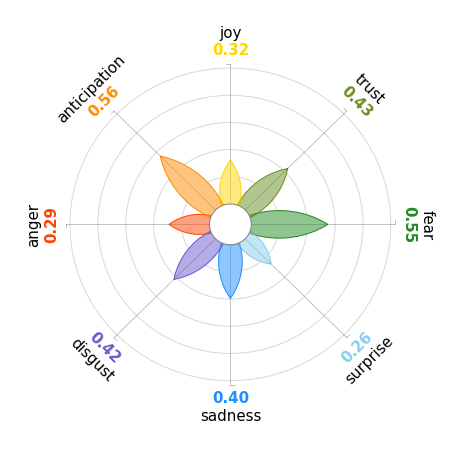

In [ ]:
from pyplutchik import plutchik
import matplotlib.pyplot as plt
from random import uniform

#Must be one of 'joy', 'trust', 'fear', 'surprise', 'sadness', 'disgust', 'anger', 'anticipation'


plutchik(dict(emotions_plutchik.mean()))

# Analysing influence of sentiment on viewership performance

### Reading in data to not have to rerun sentiment analysis code

In [1]:
import pandas as pd

twitch_views = pd.read_csv('https://raw.githubusercontent.com/JefNtungila/Sentiment-Analysis-of-Usernames-and-Titles-on-YouTube-and-Twitch/main/data/twitch_views.csv')
#dropping few values for which no emotion was returned
twitch_views = twitch_views[twitch_views['emotion'].notna()]
#converting percentage increase to values to actual scale
twitch_views['percentage_increase'] = round(twitch_views['percentage_view_increase']*100)

## Producing percentage valence polarity per genre

In [2]:
twitch_views['name_sentiment_polarity'].value_counts()

neutral     18347
negative     2901
positive     2231
Name: name_sentiment_polarity, dtype: int64

In [3]:
#percentage polarity per genre 
twitch_views[twitch_views['genre'] == 'MMO']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.650651
positive    0.265472
negative    0.083876
Name: name_sentiment_polarity, dtype: float64

In [4]:
#percentage polarity per genre 
twitch_views[twitch_views['genre'] == 'Misc']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.763267
negative    0.173504
positive    0.063229
Name: name_sentiment_polarity, dtype: float64

In [5]:
#percentage polarity per genre 
twitch_views[twitch_views['genre'] == 'Strategy']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.828995
negative    0.148590
positive    0.022415
Name: name_sentiment_polarity, dtype: float64

In [6]:
#percentage polarity per genre 
twitch_views[twitch_views['genre'] == 'Action']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.785911
negative    0.110873
positive    0.103216
Name: name_sentiment_polarity, dtype: float64

In [7]:
#percentage polarity per genre 
twitch_views[twitch_views['genre'] == 'Shooter']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.804180
negative    0.104911
positive    0.090909
Name: name_sentiment_polarity, dtype: float64

In [8]:
#percentage polarity per genre 
twitch_views[twitch_views['genre'] == 'Other']['name_sentiment_polarity'].value_counts(normalize = True)

neutral     0.786944
negative    0.119479
positive    0.093577
Name: name_sentiment_polarity, dtype: float64

## Analysing boxplots of percentage increase viewership per genre

Text(0.5, 1.0, 'Effect of Sentiment on Viewership Increase - Twitch')

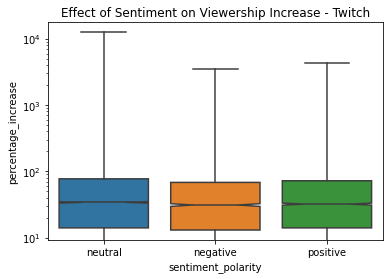

In [9]:
import seaborn as sns

#investigating the influence of sentiment on viewership performance

my_order = ['neutral', 'negative', 'positive']

boxplot1 = sns.boxplot(x='sentiment_polarity', y='percentage_increase', 
                  data=twitch_views, whis=[0, 100], notch = True, order = my_order)
boxplot1.set(yscale='log')
boxplot1.set_title('Effect of Sentiment on Viewership Increase - Twitch')

Text(0.5, 1.0, 'Effect of Name Sentiment on Viewership Increase - Twitch')

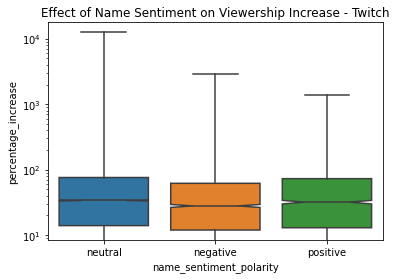

In [10]:
import seaborn as sns

my_order = ['neutral', 'negative', 'positive']

boxplot2 = sns.boxplot(x='name_sentiment_polarity', y='percentage_increase', order = my_order,
                  data=twitch_views, whis=[0, 100], notch = True)
boxplot2.set(yscale='log')
boxplot2.set_title('Effect of Name Sentiment on Viewership Increase - Twitch')

In [11]:
def emotion_aggregator(emotion):
  '''
  function takes in emotion dictionary 
  and returns biggest value of emotion detected in series
  '''
  emotion = eval(emotion)
  del emotion['negative']
  del emotion['positive']
  del emotion['anticip']
  emotion = max(emotion, key=emotion.get)
  return emotion

In [12]:
#computing strongest emotion 
twitch_views['strongest_emotion'] = twitch_views['emotion'].apply(lambda x: emotion_aggregator(x))

Text(0.5, 1.0, 'Effect of Emotion on Viewership Increase - Twitch')

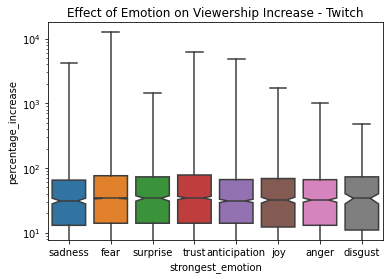

In [13]:
my_order = ['sadness', 'fear', 'surprise', 'trust', 'anticipation', 'joy', 'anger', 'disgust']

boxplot3 = sns.boxplot(x='strongest_emotion', y='percentage_increase', 
                  data=twitch_views, whis=[0, 100], notch = True, order = my_order)
boxplot3.set(yscale='log')
boxplot3.set_title('Effect of Emotion on Viewership Increase - Twitch')

## Computing median percentage increase in viewership and confidence interval of the point estimate

In [14]:
import numpy as np
from sklearn.utils import resample

def confidence_calc(data): 
  '''function takes a series in, 
    samples replacement data 10000 times
    computes the median for the replacement data and stores it
   and then gives 95% confidence interval of the medians'''

  bootstrapped_medians = []

  # prepare bootstrap sample
  for i in range(10000):
    boot = resample(data, replace=True)
    bootstrapped_medians.append(np.median(boot))
  
  a = np.percentile(bootstrapped_medians, 2.5)
  b = np.percentile(bootstrapped_medians, 97.5)

  
  return (round(a), round(b))


In [15]:
twitch_views.groupby('sentiment_polarity').median()['percentage_increase']

sentiment_polarity
negative    31.0
neutral     34.0
positive    32.0
Name: percentage_increase, dtype: float64

In [16]:
#computing 95% confidence interval for Twitch views
print(confidence_calc(twitch_views[twitch_views['sentiment_polarity']=='negative']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['sentiment_polarity']=='neutral']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['sentiment_polarity']=='positive']['percentage_increase']))

(29, 32)
(33, 35)
(32, 34)


In [ ]:
twitch_views.groupby('name_sentiment_polarity').median()['percentage_increase']

name_sentiment_polarity
negative    28.0
neutral     34.0
positive    32.0
Name: percentage_increase, dtype: float64

In [17]:
#computing confidence interval of median values
print(confidence_calc(twitch_views[twitch_views['name_sentiment_polarity']=='negative']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['name_sentiment_polarity']=='neutral']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['name_sentiment_polarity']=='positive']['percentage_increase']))

(27, 30)
(33, 35)
(30, 35)


In [ ]:
twitch_views.groupby('strongest_emotion').median()['percentage_increase']

strongest_emotion
anger           32.0
anticipation    31.0
disgust         34.0
fear            34.0
joy             32.0
sadness         31.0
surprise        34.0
trust           34.5
Name: percentage_increase, dtype: float64

In [18]:
#producing confidence interval for effect of different emotions on viewership

print(confidence_calc(twitch_views[twitch_views['strongest_emotion']=='sadness']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['strongest_emotion']=='fear']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['strongest_emotion']=='surprise']['percentage_increase']))

print(confidence_calc(twitch_views[twitch_views['strongest_emotion']=='trust']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['strongest_emotion']=='anticipation']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['strongest_emotion']=='joy']['percentage_increase']))


print(confidence_calc(twitch_views[twitch_views['strongest_emotion']=='anger']['percentage_increase']))
print(confidence_calc(twitch_views[twitch_views['strongest_emotion']=='disgust']['percentage_increase']))




(29, 34)
(33, 34)
(30, 37)
(32, 37)
(29, 34)
(28, 34)
(29, 34)
(28, 45)


## Computing ranked ANOVA to understand significance of difference in ranked median

In [ ]:
#computing ranked ANOVA  for twitch views
x = twitch_views[twitch_views['sentiment_polarity']=='negative']['percentage_increase']
y = twitch_views[twitch_views['sentiment_polarity']=='neutral']['percentage_increase']
z = twitch_views[twitch_views['sentiment_polarity']=='positive']['percentage_increase']
st.kruskal(x, y, z)



KruskalResult(statistic=21.02442396110231, pvalue=2.720221972239175e-05)

In [ ]:
#computing ranked ANOVA for twitch views
x = twitch_views[twitch_views['name_sentiment_polarity']=='negative']['percentage_increase']
y = twitch_views[twitch_views['name_sentiment_polarity']=='neutral']['percentage_increase']
z = twitch_views[twitch_views['name_sentiment_polarity']=='positive']['percentage_increase']
st.kruskal(x, y, z)


KruskalResult(statistic=48.55947472174362, pvalue=2.853934766890485e-11)

In [ ]:
#computing ranked ANOVA for twitch views

x = twitch_views[twitch_views['strongest_emotion']=='sadness']['percentage_increase']
y = twitch_views[twitch_views['strongest_emotion']=='fear']['percentage_increase']
z = twitch_views[twitch_views['strongest_emotion']=='surprise']['percentage_increase']

a = twitch_views[twitch_views['strongest_emotion']=='trust']['percentage_increase']
b = twitch_views[twitch_views['strongest_emotion']=='anticipation']['percentage_increase']
c = twitch_views[twitch_views['strongest_emotion']=='joy']['percentage_increase']


d = twitch_views[twitch_views['strongest_emotion']=='anger']['percentage_increase']
e = twitch_views[twitch_views['strongest_emotion']=='disgust']['percentage_increase']

st.kruskal(x, y, z, a, b, c, d, e)

KruskalResult(statistic=20.155746375737106, pvalue=0.005242918159175005)